# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:

# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)


Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head(2)

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
import warnings
warnings.filterwarnings("ignore")
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 160176/160176 [01:01<00:00, 2618.16it/s]


In [0]:
final['CleanedText']=preprocessed_reviews
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...


In [0]:
final['Score'].value_counts()

1    134799
0     25377
Name: Score, dtype: int64

1 as positive <br>
0 as negative

In [0]:
data=final.sample(100000)

In [0]:
print("For 100000 samples :\n" , data['Score'].value_counts())

For 100000 samples :
 1    84141
0    15859
Name: Score, dtype: int64


In [0]:
#Sorting According to Time
data["Time"] = pd.to_datetime(data["Time"], unit = "s")
data = data.sort_values(by = "Time")
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...


In [0]:
# this is for 100k points
X=data['CleanedText']
y=data['Score']

In [0]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=False)
print(X_train.shape, y_train.shape, x_test.shape)

(70000,) (70000,) (30000,)


## Bag of words

In [0]:
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train)
X_train_bow

<70000x49820 sparse matrix of type '<class 'numpy.int64'>'
	with 2314334 stored elements in Compressed Sparse Row format>

In [0]:
x_test_bow = bow.transform(x_test)

In [0]:
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(x_test_bow.shape, y_test.shape)

After vectorizations
(70000, 49820) (70000,)
(30000, 49820) (30000,)


In [0]:
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

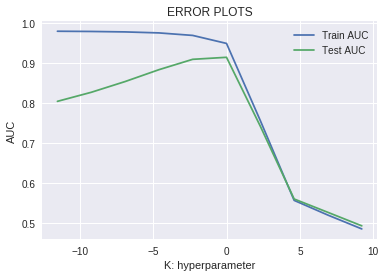

In [0]:
from pylab import scatter
import pylab
import math

train_auc = []
test_auc = []
K = [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for i in K:
    neigh = MultinomialNB(alpha=i)
    neigh =neigh.fit(X_train_bow, y_train)
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_test_pred =  neigh.predict_proba(x_test_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    test_auc.append(roc_auc_score(y_test, y_test_pred))

#plt.plot(np.log(K), train_auc, label='Train AUC')
plt.plot(list(map(lambda x:math.log(x),K)), train_auc, label='Train AUC')
plt.plot(list(map(lambda y:math.log(y),K)), test_auc, label='Test AUC')
#plt.plot(np.log(K), test_auc, label='Test AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
# determining best alpha using train score
optimal_alpha = K[train_auc.index(max(train_auc))]
print('\nThe optimal number of alpha is %f.' % optimal_alpha)
print('-'*100)

#Test_Auc=[test_auc]
# determining best alpha using test score(cv score)
optimal_alpha1 = K[test_auc.index(max(test_auc))]
print('\nThe optimal number of alpha is %f.' % optimal_alpha1) # Using this as optimal alpha


The optimal number of alpha is 0.000010.
----------------------------------------------------------------------------------------------------

The optimal number of alpha is 1.000000.


In [0]:
# instantiate learning model alpha = optimal_alpha
################# AS SAID IN THE SUGGESTION IMPLEMENTED MAX TEST SCORE AS OPTIMAL ALPHA INSTEAD OF TRAIN SCORE.
nb_optimal = MultinomialNB(alpha = optimal_alpha1)
# fitting the model
nb_optimal.fit(X_train_bow, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [0]:
# predict the response
pred_bow = nb_optimal.predict(x_test_bow)

# To get all the features name 
bow_features = bow.get_feature_names()

# Empirical log probability of features given a class(i.e. P(x_i|y))
log_prob = nb_optimal.feature_log_prob_

feature_prob_bow = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr_bow = feature_prob_bow.T
feature_prob_tr_bow.shape

(49820, 2)

In [0]:
# To show top 10 feature from both class
# Feature Importance

print("Top 10 Negative Features:-\n",feature_prob_tr_bow[0].sort_values(ascending = False)[0:10])

print("\n\n Top 10 Positive Features:-\n",feature_prob_tr_bow[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 not       -3.379733
like      -4.501545
would     -4.747438
taste     -4.770904
product   -4.807168
one       -4.959952
coffee    -5.146783
good      -5.202188
flavor    -5.269238
no        -5.278862
Name: 0, dtype: float64


 Top 10 Positive Features:-
 not      -3.745073
like     -4.572856
good     -4.708361
great    -4.766213
one      -4.892985
taste    -4.999029
coffee   -5.033598
tea      -5.106331
would    -5.116029
love     -5.118094
Name: 1, dtype: float64


In [0]:
pred_bow1=nb_optimal.predict(X_train_bow)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_bow = roc_auc_score(y_test, pred_bow)
print('\nThe auc of the naive bayes classifier for alpha = %f is %f%%' % (optimal_alpha1, auc_bow))


The auc of the naive bayes classifier for alpha = 1.000000 is 0.793157%


[[ 3286  1973]
 [  953 23788]]
   


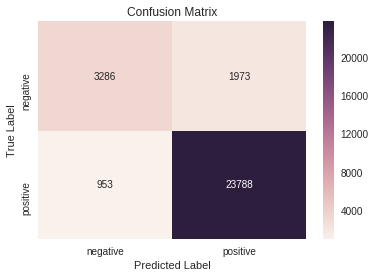

***************************************************************************
[[ 7558  3042]
 [ 1942 57458]]
   


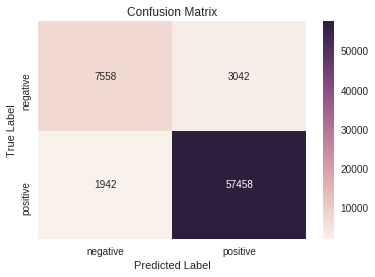

In [0]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_bow = confusion_matrix(y_test, pred_bow)
print(cm_bow)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('***************************************************************************')

cm_bow1 = confusion_matrix(y_train, pred_bow1)
print(cm_bow1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label1 = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm_bow1, index = class_label1, columns = class_label1)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
print("Tp , Tn , Fp , Fn")
confusion=cm_bow.ravel()
confusion[0]

Tp , Tn , Fp , Fn


3286

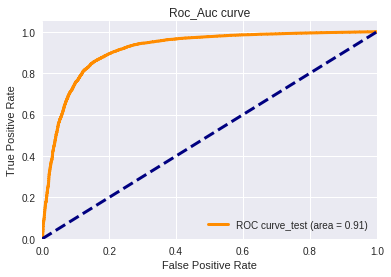

In [0]:
### Compute ROC curve and ROC area for predictions on validation set
from sklearn import metrics
y_test_predict =  nb_optimal.predict_proba(x_test_bow)[:,1]
fpr1,tpr1,_ =  metrics.roc_curve(y_train,pred_bow1) 
fpr,tpr, _ = metrics.roc_curve(y_test,y_test_predict)

roc_auc = auc(fpr, tpr) 
roc_auc1 = auc(fpr1,tpr1) 
### Plot
plt.figure()
lw = 3
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1] , color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

In [0]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_bow))
print('**'*50)
print(classification_report(y_train, pred_bow1))

              precision    recall  f1-score   support

           0       0.78      0.62      0.69      5259
           1       0.92      0.96      0.94     24741

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.85      0.79      0.82     30000
weighted avg       0.90      0.90      0.90     30000

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.80      0.71      0.75     10600
           1       0.95      0.97      0.96     59400

   micro avg       0.93      0.93      0.93     70000
   macro avg       0.87      0.84      0.86     70000
weighted avg       0.93      0.93      0.93     70000



## Tf-Idf

In [0]:
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=2000 , ngram_range=(1,2))
X_train_tfidf = tf_idf_vect.fit_transform(X_train)
X_train_tfidf

<70000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 1980925 stored elements in Compressed Sparse Row format>

In [0]:
# Convert test text data to its vectorizor
x_test_tfidf = tf_idf_vect.transform(x_test)
x_test_tfidf.shape

(30000, 2000)

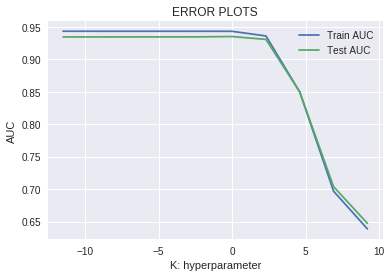

In [0]:
train_auc1 = []
test_auc1 = []
K1 =  [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for i1 in K1:
    neigh_tfidf= MultinomialNB(alpha=i1)
    neigh_tfidf.fit(X_train_tfidf, y_train)
    y_train_pred_tfidf = neigh_tfidf.predict_proba(X_train_tfidf)[:,1]
    y_test_pred_tfidf =  neigh_tfidf.predict_proba(x_test_tfidf)[:,1]
    
    train_auc1.append(roc_auc_score(y_train,y_train_pred_tfidf))
    test_auc1.append(roc_auc_score(y_test, y_test_pred_tfidf))

plt.plot(list(map(lambda x:math.log(x),K1)), train_auc1, label='Train AUC')
plt.plot(list(map(lambda y:math.log(y),K1)), test_auc1, label='Test AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:

# determining best alpha
optimal_alpha_tfidf = K1[train_auc1.index(max(train_auc1))]
print('\nThe optimal number of alpha is %f.' % optimal_alpha_tfidf)
print('-'*100)
# determining best alpha
optimal_alpha1_tfidf = K1[test_auc1.index(max(test_auc1))]
print('\nThe optimal number of alpha is %f.' % optimal_alpha1_tfidf)


The optimal number of alpha is 0.000010.
----------------------------------------------------------------------------------------------------

The optimal number of alpha is 1.000000.


In [0]:
# instantiate learning model alpha = optimal_alpha
nb_optimal_tfidf = MultinomialNB(alpha = optimal_alpha1_tfidf)
nb_optimal_tfidf

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [0]:

# fitting the model
nb_optimal_tfidf.fit(X_train_tfidf, y_train)

predict_tfidf = nb_optimal_tfidf.predict(x_test_tfidf)
predict_tfidf1=nb_optimal_tfidf.predict(X_train_tfidf)

In [0]:
tfidf_features = tf_idf_vect.get_feature_names() # to get features 

# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob_tfidf = nb_optimal_tfidf.feature_log_prob_

feature_prob_tfidf = pd.DataFrame(log_prob_tfidf, columns = tfidf_features)
feature_prob_tr_tfidf = feature_prob_tfidf.T
feature_prob_tr_tfidf.shape

(2000, 2)

In [0]:
print("Top 10 Negative Features:-\n",feature_prob_tr_tfidf[0].sort_values(ascending = False)[0:10])

print("\n\n Top 10 Positive Features:-\n",feature_prob_tr_tfidf[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 not       -4.091667
like      -4.900591
product   -4.995491
taste     -5.006343
would     -5.033030
coffee    -5.218535
one       -5.295370
no        -5.443818
flavor    -5.457360
good      -5.533966
Name: 0, dtype: float64


 Top 10 Positive Features:-
 not       -4.639317
great     -4.983132
good      -5.053964
like      -5.104101
coffee    -5.145453
tea       -5.196682
love      -5.228836
one       -5.324333
product   -5.338716
taste     -5.355894
Name: 1, dtype: float64


In [0]:
auc_tfidf = roc_auc_score(y_test, predict_tfidf) 
print('\nThe auc of the naive bayes classifier for alpha = %f is %f%%' % (optimal_alpha1_tfidf, auc_tfidf))


The auc of the naive bayes classifier for alpha = 1.000000 is 0.623534%


[[ 1314  3945]
 [   69 24672]]




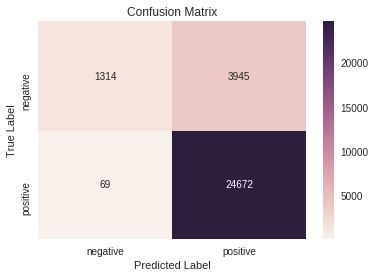

****************************************************************************************************
[[ 2604  7996]
 [  156 59244]]




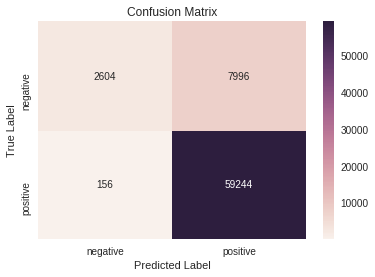

In [0]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test,predict_tfidf)
print(conf_matrix)
print('\n')
class_label_tfidf = ["negative", "positive"]
df_cm_tfidf = pd.DataFrame(conf_matrix, index = class_label_tfidf, columns = class_label_tfidf)
sns.heatmap(df_cm_tfidf, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print('**'*50)
conf_matrix1 = confusion_matrix(y_train,predict_tfidf1)
print(conf_matrix1)
print('\n')
class_label_tfidf1 = ["negative", "positive"]
df_cm_tfidf1 = pd.DataFrame(conf_matrix1, index = class_label_tfidf1, columns = class_label_tfidf1)
sns.heatmap(df_cm_tfidf1, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

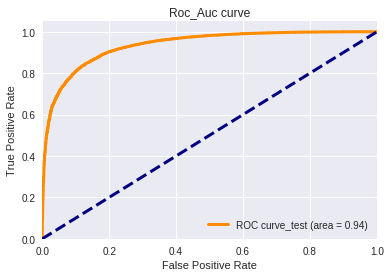

In [0]:
### Compute ROC curve and ROC area for predictions on validation set
from sklearn import metrics
y_test_predict_tfidf =  nb_optimal_tfidf.predict_proba(x_test_tfidf)[:,1]
fpr1_tfidf,tpr1_tfidf,_ =  metrics.roc_curve(y_train,predict_tfidf1)
fpr_tfidf,tpr_tfidf,_ = metrics.roc_curve(y_test, y_test_predict_tfidf) 

roc_auc_tfidf = auc(fpr_tfidf,tpr_tfidf) 
roc_auc1_tfidf = auc(fpr1_tfidf,tpr1_tfidf)
### Plot
plt.figure()
lw = 3
plt.plot(fpr_tfidf,tpr_tfidf, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc_tfidf)
plt.plot([0,1],[0,1] , color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_tfidf))
print(classification_report(y_train, predict_tfidf1))

              precision    recall  f1-score   support

           0       0.95      0.25      0.40      5259
           1       0.86      1.00      0.92     24741

   micro avg       0.87      0.87      0.87     30000
   macro avg       0.91      0.62      0.66     30000
weighted avg       0.88      0.87      0.83     30000

              precision    recall  f1-score   support

           0       0.94      0.25      0.39     10600
           1       0.88      1.00      0.94     59400

   micro avg       0.88      0.88      0.88     70000
   macro avg       0.91      0.62      0.66     70000
weighted avg       0.89      0.88      0.85     70000



 #### The final metric of Analysis for Navie bayes is clearly mentioned with above code and auc in below table.
-----------------------------------------------------------------------------------
|Model |  AUC         | Alpha |
  |--------------------------------------------------|
|Bow   |  0.7903    |     1.000     |
                 |--------------------------------------------------|
|Tfidf  | 0.616        |     1.000    |
                 |--------------------------------------------------|